# Regime Forecasting III

## 1. Set Up Environment and Read Data <a id="1"></a>

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from matplotlib import pyplot as mp
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Dataset_Cleaned.csv')

Label = df["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df.insert(loc=2, column="Label", value=Label.values)

df.head()


,Date,Regime,Label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
0,9/1/60,Recession,0.0,-0.277761,-0.295013,-0.212118,0.401363,-0.321981,-0.764446,-0.632790,...,-0.076853,-0.092745,-0.087114,-0.085455,-0.099002,-0.454463,-0.566992,-0.395095,-0.450998,-0.089005
1,10/1/60,Recession,0.0,-0.204460,-0.161434,-0.204519,-0.978339,-0.239615,-0.308591,0.059474,...,-0.081327,-0.084890,-0.103429,-0.089335,-0.090643,-0.255545,-0.415804,-0.483302,-0.473520,0.147174
2,11/1/60,Recession,0.0,-0.520186,-0.577658,-0.785798,-0.611700,-0.435990,-0.935469,-0.748034,...,-0.084509,-0.087674,-0.095868,-0.095503,-0.087956,-0.404823,-0.392308,-0.605015,-0.445070,-0.091651
3,12/1/60,Recession,0.0,-0.531320,-0.581530,-1.397470,0.071269,-0.375495,-1.163499,-0.921200,...,-0.095048,-0.076637,-0.094476,-0.087146,-0.076214,-0.331993,-0.453979,-0.578110,-0.389378,-0.070555
4,1/1/61,Normal,1.0,0.054513,0.096044,-0.375484,-1.608684,-0.307555,-0.194576,-0.286457,...,-0.103002,-0.081112,-0.086616,-0.103462,-0.076910,-0.250758,-0.253854,-0.425585,-0.477942,0.167308


In [3]:
df.tail()

,Date,Regime,Label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
692,5/1/18,Normal,1.0,-0.158774,-0.087869,0.961837,0.428800,2.458364,-2.071505,-3.897094,...,-0.482484,0.035214,-0.213850,0.107884,-0.230363,-2.969053,0.961673,0.029818,0.229887,-2.082950
693,6/1/18,Normal,1.0,0.349410,0.372881,0.885853,0.063037,0.230187,1.119480,1.231754,...,-0.658796,-0.179194,-0.133821,0.236277,-0.197709,-1.758884,2.236719,0.274491,-1.001393,-0.345305
694,7/1/18,Normal,1.0,0.225752,0.198647,0.954238,0.150980,1.059808,0.675562,-0.051761,...,0.108564,-0.311340,-0.144057,-0.120563,-0.293692,-1.727882,-0.918590,0.481157,-0.256506,1.560538
695,8/1/18,Normal,1.0,0.496621,0.504524,0.802270,0.788034,-0.474700,1.659097,0.954768,...,0.104177,-0.482299,0.033552,-0.213885,-0.613278,0.143563,-2.983834,0.964076,0.037260,0.000571
696,9/1/18,Normal,1.0,-0.077029,-0.231128,-0.561645,0.393889,-0.817945,0.153438,0.379952,...,-0.324269,-0.658623,-0.180970,-0.133855,-0.085913,2.453857,-1.766319,2.250399,0.282925,-0.081374


## 2. Methodology <a id="2"></a>

Our exercise will be based on classification problem. We have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms.

1. We will perform feature selection before making our forecasts. We will use $L_1$ regularized logistic regression for that purpose.

2. Separate dataset into training and validation datasets. Split based dataset based on time: the period over 1960-1996 is selected for training and the period over 1996-2018 is kept for validation

3. Evaluate performances of the machine learning algorithms on training dataset with cross validation (CV). Since we have time series structure we will use a special type of CV function in Python,__[`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)__. We will use Receiver operating characteristic (ROC) as scoring metric in our models. Related Python functions for this metric are __[`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)__  and  __[`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)__.

4. Select the best performing models based on average accuracy and standard deviation of the CV results. We will take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem.

5. Then we make predictions on the validation dataset with selected models. First, we use __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ for selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on validation dataset and report accuracy metrics and feature importance results.

## 3. Feature Selection with $L_1$ Penalty <a id="3"></a>

In [4]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

In [5]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

435 435 697
262 262 697


In [6]:
scoring="roc_auc"
kfold= model_selection.TimeSeriesSplit(n_splits=3)
seed=8

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C)

model=LogisticRegression(max_iter=10000,penalty='l1')
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(X=df_features,
                                                                       y=df_targets).best_estimator_

LR_penalty

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
X=df_features
y=df_targets
lr_l1 = LogisticRegression(C=0.1, max_iter=10000,penalty="l1").fit(X,y)
model = SelectFromModel(lr_l1,prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = model.transform(X)
X_new.shape

(697, 35)

In [8]:
feature_name

Index(['DPCERA3M086SBEA', 'IPFPNSS', 'IPMANSICS', 'HWI', 'UNRATE', 'PAYEMS',
       'SRVPRD', 'USTPU', 'USWTRADE', 'USFIRE', 'HOUST', 'HOUSTW',
       'S&P div yield', 'TB3MS', 'TB3SMFFM', 'IPMAT 9M lag', 'IPDMAT 12M lag',
       'CLAIMSx 9M lag', 'DMANEMP 12M lag', 'USFIRE 3M lag', 'AWOTMAN 18M lag',
       'BUSLOANS 6M lag', 'S&P 500 6M lag', 'S&P div yield 3M lag',
       'TB3MS 6M lag', 'AAA 3M lag', 'TB3SMFFM 3M lag', 'T1YFFM 6M lag',
       'T5YFFM 6M lag', 'T10YFFM 6M lag', 'T10YFFM 12M lag', 'EXUSUKx 12M lag',
       'WPSID62 9M lag', 'OILPRICEx 9M lag', 'CUSR0000SAD 3M lag'],
      dtype='object')

In [9]:
df_2=df[feature_name]
df_2.insert(loc=0, column="Date", value=df['Date'].values)
df_2.insert(loc=1, column="Regime", value=df['Regime'].values)
df_2.insert(loc=2, column="Label", value=df['Label'].values)

df_2.head()
df_2.shape

(697, 38)

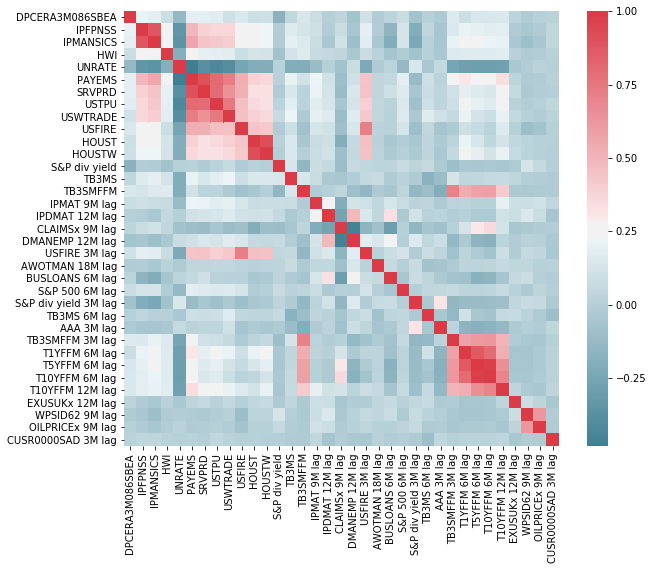

In [10]:
corr = df_2.drop(['Date','Regime','Label'],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## 4. Training Algorithms on Training Dataset <a id="3"></a>

For a detail description of the machine learning algorithms you can check scikit-learn's documentation __[here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)__.

In [11]:
df=df_2
df.shape

(697, 38)

In [12]:
# Time Series Split
df_idx = df[df.Date == '12/1/96'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

LR: 0.877570 (0.047838)
LR_L1: 0.934921 (0.031076)
LR_L2: 0.928582 (0.040605)
LDA: 0.858740 (0.063361)
KNN: 0.837252 (0.115853)
GB: 0.790105 (0.115667)
ABC: 0.868133 (0.045829)
RF: 0.933246 (0.020609)
XGB: 0.878555 (0.063837)


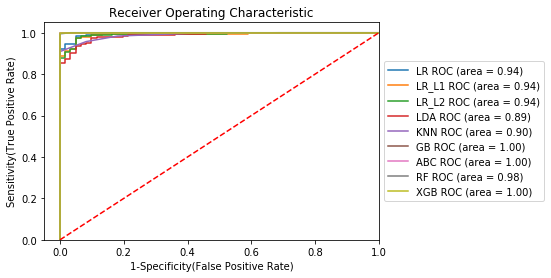

In [13]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=3) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 
warnings.filterwarnings('ignore')

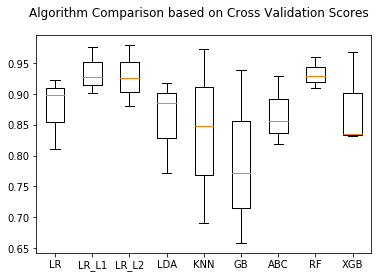

In [14]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

In [15]:
model=LogisticRegression(C=1e09) # high penalty 
LR=model.fit(df_training_features,df_training_targets)
training_predictions=LR.predict(df_training_features)
prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)

In [16]:
import datetime
# define periods of recession
rec_spans = []
#rec_spans.append([datetime.datetime(1957,8,1), datetime.datetime(1958,4,1)])
rec_spans.append([datetime.datetime(1960,4,1), datetime.datetime(1961,2,1)])
rec_spans.append([datetime.datetime(1969,12,1), datetime.datetime(1970,11,1)])
rec_spans.append([datetime.datetime(1973,11,1), datetime.datetime(1975,3,1)])
rec_spans.append([datetime.datetime(1980,1,1), datetime.datetime(1980,6,1)])
rec_spans.append([datetime.datetime(1981,7,1), datetime.datetime(1982,10,1)])
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,2,1)])
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,10,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,5,1)])

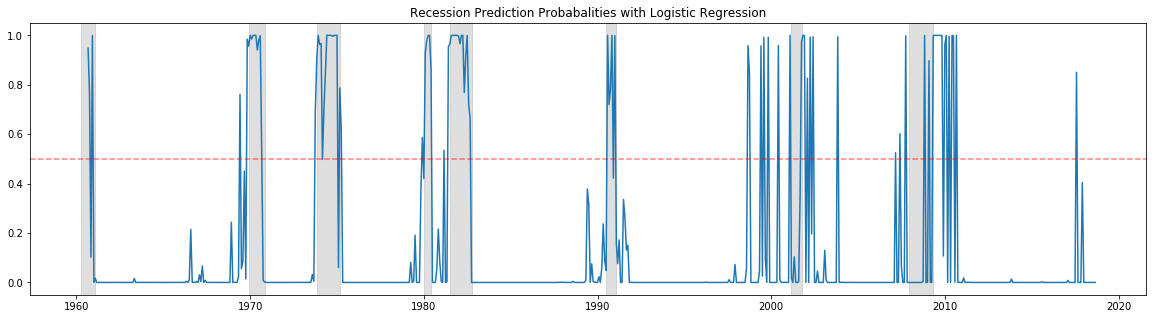

In [17]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
mp.savefig('plot1.png',  bbox_inches='tight')
plt.show()

### Logistic Regression with Regularization

In [18]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [19]:
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0)

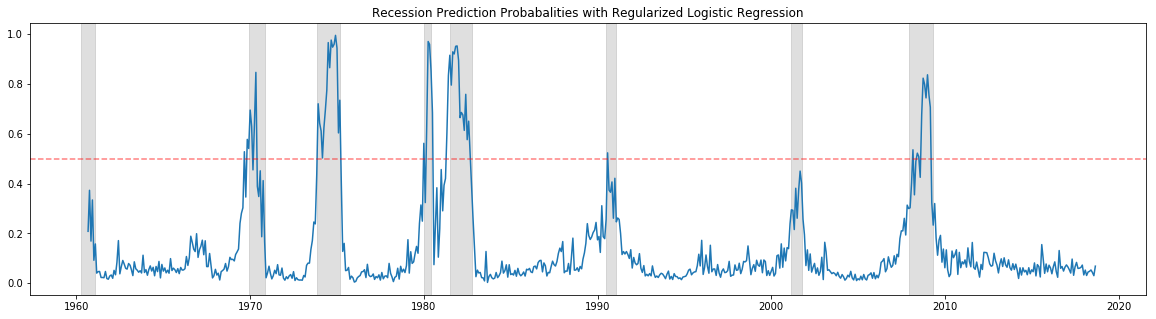

In [20]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

### XGBoosting

In [21]:
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree']},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
prob_predictions = xgboost.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, xgboost.predict_proba(df_validation_features), axis=0)

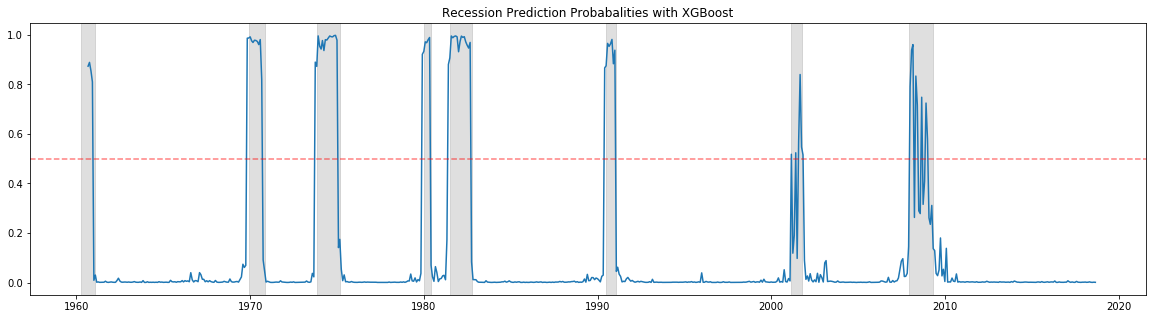

In [23]:
sample_range = pd.date_range(start='9/1/1960', end='9/1/2018', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
mp.savefig('plot3.png',  bbox_inches='tight')
plt.show()

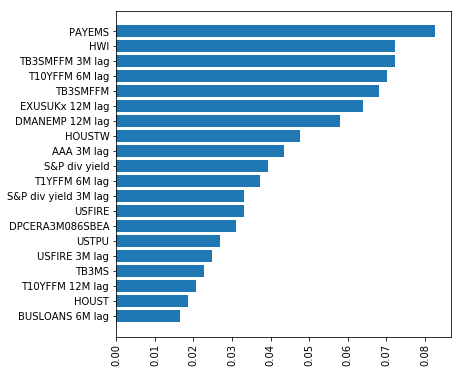

In [27]:
# find feature importances
headers = df.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
xgboost_importances = pd.DataFrame(xgboost.feature_importances_, index = headers, columns = ['Relative Importance'])
_ = xgboost_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
xgboost_importances = xgboost_importances[xgboost_importances['Relative Importance']>0].iloc[:20]

# display importances in bar-chart and pie-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(xgboost_importances)), width=xgboost_importances['Relative Importance'], align='center', tick_label=xgboost_importances.index)
plt.gca().invert_yaxis()
mp.savefig('feature_importance.png',  bbox_inches='tight')
plt.show()

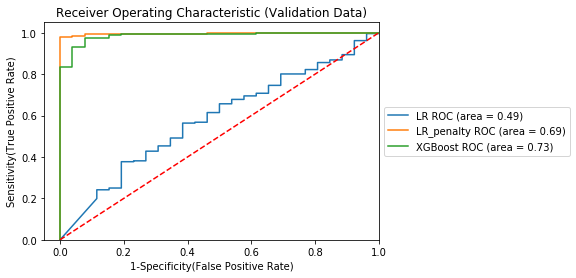

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR_penalty.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

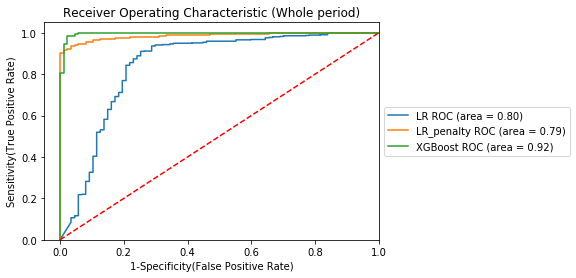

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))


fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR_penalty.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 